# Simply Supported Beam as a Membrane

In this example we model a simply supported beam as a membrane, under the effect of a constant distributed load. We run run a linear analysis and do some plotting with both `AxisVM` and `matplotlib`.

***

## Create a COM interface to a new instance of AxisVM

We create a new instance of AxisVM, and make it visible. For the meaning of the argument `daemon=True`, take a look on the docstring of the function.

In [1]:
from axisvm.com.client import start_AxisVM
axvm = start_AxisVM(visible=True, daemon=True)


The type library itself can be imported as

In [2]:
import axisvm.com.tlb as axtlb

If this is not the first time, this import statement can be at the top of the unit.

Create a new model and set the working directory. An empty string means the directory where AxisVM.exe is located:

In [3]:
modelId = axvm.Models.New()
axm = axvm.Models[modelId]
wdir = ""


## Input data

When talking about input data, don't forget, that AxisVM internally stores values in $kN$ and $m$.

In [4]:
L = 10.0  # length of the beam
h = 2.0  # height of the cross-section
b = 0.2  # width of the cross section
pz = -10.0  # intensity of vertical distributed load
px = 0.0  # intensity of horizontal distributed load


## Material

Set Eurocode as the standard and "C16/20" concrete form the material library.

In [5]:
axm.Settings.NationalDesignCode = axtlb.ndcEuroCode
matId = axm.Materials.AddFromCatalog(axtlb.ndcEuroCode, "C16/20")


## Geometry

The definition of a geometry of a model follows a hierarchical workflow. This means, that we cannot directly define the domains. Instead, we first define the nodes that make up the lines, with which finally we define the domains.

We create the beam as two touching domains, which makes up for a total of 6 nodes. We also store the indices of the defined nodes as a reference for creating the lines.

In [6]:
import numpy as np
from axisvm.com.tlb import dofYfix

coords = np.zeros((6, 3))  # we have six points in a 3d space
coords[0, :] = 0., 0., -h/2
coords[1, :] = 0., 0., 0.
coords[2, :] = 0., 0., h/2
coords[3, :] = L, 0., -h/2
coords[4, :] = L, 0., 0.
coords[5, :] = L, 0., h/2

# we are working in the x-z plane, so all nodes are supported
# against displacement in y-direction
fnc = axm.Nodes.AddWithDOF
nodeIDs = list(map(lambda c: fnc(*c, dofYfix), coords))


We define the lines that make up the domains and store their indices in a `list`. 

In [7]:
nodes_of_lines = [[0, 1], [1, 2], [3, 4], [4, 5], [0, 3], [1, 4], [2, 5]]
LineGeomType = axtlb.lgtStraightLine
lineIDs = []
for line in nodes_of_lines:
    lineIDs.append(axm.Lines.Add(nodeIDs[line[0]], nodeIDs[line[1]],
                   LineGeomType, axtlb.RLineGeomData())[1])


Now we are in a position to create the domains by providing lineIDs.

In [8]:
from axisvm.com.tlb import RSurfaceAttr, lnlTensionAndCompression, \
    RResistancesXYZ, schLinear, stMembraneStress, RElasticFoundationXYZ, \
    RNonLinearityXYZ

sattr = RSurfaceAttr(
    Thickness=b,
    SurfaceType=stMembraneStress,
    RefZId=0,
    RefXId=0,
    MaterialId=matId,
    ElasticFoundation=RElasticFoundationXYZ(0, 0, 0),
    NonLinearity=RNonLinearityXYZ(lnlTensionAndCompression,
                                  lnlTensionAndCompression,
                                  lnlTensionAndCompression),
    Resistance=RResistancesXYZ(0, 0, 0),
    Charactersitics=schLinear)

lines_of_domains = [[0, 4, 2, 5], [1, 5, 3, 6]]
domainIDs = []
for d in lines_of_domains:
    domainIDs.append(axm.Domains.Add(LineIds=[lineIDs[i] for i in d],
                                     SurfaceAttr=sattr)[1])


## Loads

We add a line load on the whole span of the beam with the specified load intensities.

In [9]:
lines3d = axvm.ObjectCreator.NewLines3d()
line3d = axtlb.RLine3d(
    LineType=axtlb.ltStraightLine3d,
    P1=axtlb.RPoint3d(0, 0, 0),
    P2=axtlb.RPoint3d(L, 0, 0)
)
lines3d.Add(line3d)
LoadDomainPolyLine = axtlb.RLoadDomainPolyLine(
    LoadCaseId=1,
    px1=px,
    px2=px,
    py1=0,
    py2=0,
    pz1=pz,
    pz2=pz,
    DistributionType=axtlb.dtGlobal,
    Nx=0,
    Ny=0,
    Nz=1
)
_ = axm.Loads.AddDomainPolyLine(lines3d, LoadDomainPolyLine)


## Supports

We add two hinged supports at the ends.

In [10]:
springleft = axtlb.RStiffnesses(
    x=1e12,
    y=1e12,
    z=1e12,
    xx=0,
    yy=0,
    zz=0
)
springright = axtlb.RStiffnesses(
    x=1e12,
    y=1e12,
    z=1e12,
    xx=0,
    yy=0,
    zz=0
)
RNonLinearity = axtlb.RNonLinearity(
    x=axtlb.lnlTensionAndCompression,
    y=axtlb.lnlTensionAndCompression,
    z=axtlb.lnlTensionAndCompression,
    xx=axtlb.lnlTensionAndCompression,
    yy=axtlb.lnlTensionAndCompression,
    zz=axtlb.lnlTensionAndCompression
)
RResistances = axtlb.RResistances(
    x=0,
    y=0,
    z=0,
    xx=0,
    yy=0,
    zz=0
)
_ = axm.NodalSupports.AddNodalGlobal(springleft, RNonLinearity,
                                     RResistances, nodeIDs[1])
_ = axm.NodalSupports.AddNodalGlobal(springright, RNonLinearity,
                                     RResistances, nodeIDs[4])


## Meshing

We define a triangle mesh, with a mesh size of $h/5$.

In [11]:
MeshParams = axtlb.RDomainMeshParameters(
    MeshSize=h/5,
    MeshType=axtlb.mtUniform,
    MeshGeometryType=axtlb.mgtTriangle
)
axm.Domains[:].GenerateMesh(MeshParams);

Notice the use of the semicolon here. This simplifies carrying out the same operation over a range of domains. (the colon at the end simply suppresses the output).

## Processing

We save the file and run a linear analysis, with all warnings suppressed.

In [12]:
fpath = wdir + 'ss_beam_M.axs'
axm.SaveToFile(fpath, False)
axm.Calculation.LinearAnalysis(axtlb.cuiNoUserInteractionWithAutoCorrectNoShow)


1

## Plotting with AxisVM

We want to plot vertical displacements. At the end we save the plot to a file in the working directory.

In [13]:

# we want the front of the domains to fill up the screen entirely
axm.View = axtlb.vFront
axm.FitInView()

# turn off the grid
GridOptions = axtlb.RGridOptions(DisplayGrid=False)
axm.Settings.SetGridOptions(GridOptions)

WriteValuesTo = axtlb.RWriteValuesTo(
    Nodes=True,
    Lines=True,
    Surfaces=False,
    MinMaxOnly=True
)

BasicDispParams = axtlb.RBasicDisplayParameters_V153(
    ResultComponent=axtlb.rc_d_eZ,
    Scale=1.0,
    DisplayMode=axtlb.dmIsosurfaces2D,
    DisplayShape=axtlb.dsUndeformed,
    WriteValuesTo=WriteValuesTo
)

ExtDispParams = axtlb.RExtendedDisplayParameters_V153(
    BasicDispParams=BasicDispParams,
    DisplayAnalysisType=axtlb.datLinear,
    ResultType=axtlb.rtLoadCase
)
axm.Windows.SetStaticDisplayParameters_V153(1, ExtDispParams, 1, [])

axm.Windows.ReDraw()
imgpath = wdir + 'ss_beam_M_ez.bmp'
axm.Windows[1].SaveWindowToBitmap(axtlb.wcmColour, imgpath)
axvm.BringToFront()


1

## Plotting with `matplotlib`

We collect the data and create a 'minimal-effort' plot with `matplotlib`.

In [14]:
disps = axm.Results.Displacements
disps.DisplacementSystem = axtlb.dsGlobal
disps.LoadCaseId = 1
disps.LoadLevelOrModeShapeOrTimeStep = 1

# IDs of all the nodes in the model
nIDs = [i+1 for i in range(axm.Nodes.Count)]

# displacement data
def fnc(i): return disps.NodalDisplacementByLoadCaseId(i)[0].ez
data = np.array(list(map(fnc, nIDs)))

# coordinates of the nodes as a numpy array
coords = axm.Nodes.BulkGetCoord(nIDs)[0]
coords = np.array([[n.x, n.y, n.z] for n in coords])

# get the topology as a numpy array
def fnc(i): return axm.Surfaces.Item[i].GetContourPoints()[0]
sIDs1 = axm.Domains.Item[1].MeshSurfaceIds
tri1 = np.vstack(list(map(fnc, sIDs1))) - 1
sIDs2 = axm.Domains.Item[2].MeshSurfaceIds
tri2 = np.vstack(list(map(fnc, sIDs2))) - 1
triangles = np.vstack((tri1, tri2))


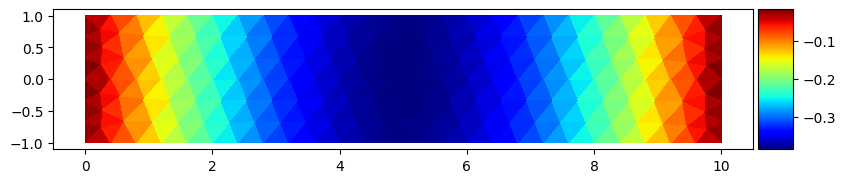

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.tri as tri
import matplotlib.pyplot as plt

%matplotlib inline

px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots(figsize=(800*px, 200*px))
triobj = tri.Triangulation(coords[:, 0], coords[:, 2], triangles=triangles)
triplot = ax.tripcolor(triobj, data*1000, cmap='jet')
ax.set_aspect('equal')
fig.tight_layout()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(triplot, cax=cax)
plt.show()


## Close AxisVM

Because we created the interface with `daemon=True`, the application closes without any warning.

In [16]:
axvm.Quit()